In [24]:
import torch
import numpy as np
from torch import nn,optim
import time
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

In [25]:
def get_data_ch7():
    data=np.genfromtxt(r'F:\study\ml\DataSet\airfoil_self_noise\airfoil_self_noise.dat',
                      delimiter='\t')
    data=(data-data.mean(axis=0)) / data.std(axis=0)
    features=torch.tensor(data[:1500,:-1],dtype=torch.float32)
    labels=torch.tensor(data[:1500,-1],dtype=torch.float32)
    return features,labels

In [26]:
features,labels=get_data_ch7()
features.shape

torch.Size([1500, 5])

In [27]:
def init_adam_states():
    s_w=torch.zeros((features.shape[1],1),dtype=torch.float32)
    s_b=torch.zeros((1),dtype=torch.float32)
    v_w=torch.zeros((features.shape[1],1),dtype=torch.float32)
    v_b=torch.zeros((1),dtype=torch.float32)
    return ((v_w,s_w),(v_b,s_b))
    

In [28]:
def adad_sge(params,states,hyperparams):
    beta1,beta2,t=0.9,0.999,hyperparams['t']
    eps=1e-6
    for p,(v,s) in zip(params,states):
        v=beta1*v+(1-beta1)*p.grad.data
        s=beta2*s+(1-beta2)*p.grad.data**2
        v_hat=v/(1-beta1**t)
        s_hat=s/(1-beta2**t)
        g_hat=hyperparams['lr']*v_hat /(torch.sqrt(s_hat)+eps)
        p.data -=g_hat


In [29]:
def linreg(x,w,b):
    return torch.mm(x,w)+b
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.shape))**2

In [32]:
def train_ch7(optimizer_fn,states,hyperparams,features,labels,
              batch_size=10,num_epochs=2):
    net,loss=linreg,squared_loss
    w = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)),
                     dtype=torch.float32,
                     requires_grad=True))
    b = nn.Parameter(
        torch.tensor(np.zeros(1), dtype=torch.float32, requires_grad=True))
    
    data_iter=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,
    shuffle=True)
    
    def eval_loss():
        return loss(net(features,w,b),labels).mean().item()/2
    
    ls=[eval_loss()]
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(X,w,b),y).mean()/2
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fn([w,b],states,hyperparams)
            if (batch_i+1)*batch_size %100 ==0:
                ls.append(eval_loss())
    print('loss : %f, %f sec per epoch' % (ls[-1],time.time()/num_epochs))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')

loss : 0.249045, 810135014.408637 sec per epoch


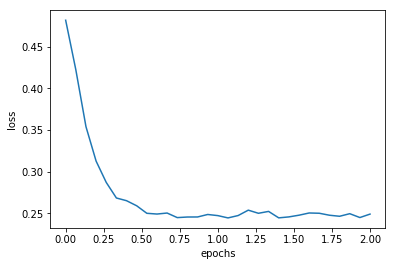

In [33]:
train_ch7(adad_sge, init_adam_states(), {'lr': 0.01, 't': 1},
features, labels)